# NIRSimple example

&rarr; [Download this notebook](https://github.com/HanBnrd/NIRSimple/blob/master/docs/source/examples/simple-probe.ipynb)

In [1]:
import scipy.io
import numpy as np
import nirsimple as ns

The data used in this example is from the [Homer MATLAB toolbox tutorial](https://homer-fnirs.org/documentation/) and can be downloaded [here](http://www.nmr.mgh.harvard.edu/martinos/software/homer/SampleData.zip).

Download the zip archive and extract it. In this example we are just going to use `Simple_Probe.nirs` which is in the `Example1_Simple_Probe` folder of the archive.

## Load data from the file

Load the file as a MATLAB file:

In [2]:
file_path = "./Simple_Probe.nirs"  # replace by the path to Simple_Probe.nirs
simple_probe = scipy.io.loadmat(file_path)

## Get fNIRS light intensities as a numpy array

Get signals from Simple Probe:

In [3]:
intensities = np.swapaxes(simple_probe['d'], 0, 1)
print("Intensity data shape: {}".format(intensities.shape))
print("  number of channels: {}".format(intensities.shape[0]))
print("  number of time points: {}".format(intensities.shape[1]))

Intensity data shape: (8, 1200)
  number of channels: 8
  number of time points: 1200


## Convert light intensities to optical density changes

Get optical density changes relative to the average intensity of each channel:

In [4]:
dod = ns.intensities_to_od_changes(intensities)
print("Delta OD shape: {}".format(dod.shape))

Delta OD shape: (8, 1200)


## Get channel info as lists

Get channel names from Simple Probe:

In [5]:
channels = simple_probe['SD']['MeasList'][0, 0][:, :2].tolist()
raw_ch_names = [str(ch).replace('[', '').replace(']', '').replace(', ', '-')
                for ch in channels]
print("Channel names: {}".format(raw_ch_names))

Channel names: ['1-1', '1-2', '1-3', '1-4', '1-1', '1-2', '1-3', '1-4']


---

Get channel wavelengths from Simple Probe:

In [6]:
wavelengths = simple_probe['SD']['Lambda'][0, 0][0].tolist()
ch_high_wl = [wavelengths[0] for _ in range(int(len(raw_ch_names)/2))]
ch_low_wl = [wavelengths[1] for _ in range(int(len(raw_ch_names)/2))]
ch_wl = ch_high_wl + ch_low_wl
print("Channel wavelengths: {}".format(ch_wl))

Channel wavelengths: [830, 830, 830, 830, 690, 690, 690, 690]


---

Define the differential pathlengths factor (DPF) for each channel:

In [7]:
unique_dpf = 6
ch_dpf = [unique_dpf for _ in enumerate(raw_ch_names)]
print("Channel DPFs: {}".format(ch_dpf))

Channel DPFs: [6, 6, 6, 6, 6, 6, 6, 6]


---

Define source-detector distance for each channel:

In [8]:
unique_distance = 2.8  # cm
ch_distances = [unique_distance for _ in enumerate(raw_ch_names)]
print("Channel distances: {}".format(ch_distances))

Channel distances: [2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8]


## Convert optical density changes to concentration changes

Get oxygenated and deoxygenated hemoglobin concentration changes (HbO and HbR) with the modified Beer-Lambert law (from Delpy et al., 1988):

In [9]:
data = ns.mbll(dod, raw_ch_names, ch_wl, ch_dpf, ch_distances,
               unit='cm', table='wray')
dc, ch_names, ch_types = data
print("Delta HbO and HbR shape: {}".format(dc.shape))
print("Channel names: {}".format(ch_names))
print("Channel types: {}".format(ch_types))

Delta HbO and HbR shape: (8, 1200)
Channel names: ['1-1', '1-1', '1-2', '1-2', '1-3', '1-3', '1-4', '1-4']
Channel types: ['hbo', 'hbr', 'hbo', 'hbr', 'hbo', 'hbr', 'hbo', 'hbr']


### Plot data with MNE

In [10]:
import mne

In [11]:
S_FREQ = 5  # sampling frequency in Hz

Plot data with MNE:

MNE channel names: ['1-1 hbo', '1-1 hbr', '1-2 hbo', '1-2 hbr', '1-3 hbo', '1-3 hbr', '1-4 hbo', '1-4 hbr']
Creating RawArray with float64 data, n_channels=8, n_times=1200
    Range : 0 ... 1199 =      0.000 ...   239.800 secs
Ready.


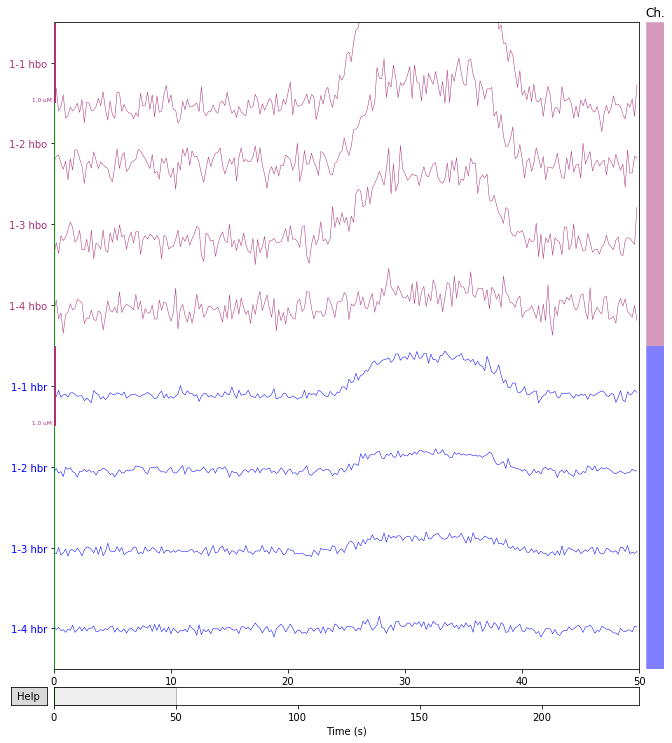

In [12]:
mne_ch_names = [ch + ' ' + ch_types[i] for i, ch in enumerate(ch_names)]
print("MNE channel names: {}".format(mne_ch_names))
info = mne.create_info(ch_names=mne_ch_names, sfreq=S_FREQ,
                       ch_types=ch_types)
raw = mne.io.RawArray(dc, info)
graph = raw.plot(scalings=0.5e-6, duration=50)

## Signal correction

Apply correlation based signal improvement (from Cui at al., 2010) to hemoglobin concentration changes:

In [13]:
data = ns.cbsi(dc, ch_names, ch_types)
dc_0, ch_names_0, ch_types_0 = data
print("Delta HbO_0 and HbR_0 shape: {}".format(dc_0.shape))
print(ch_names_0)

Delta HbO_0 and HbR_0 shape: (8, 1200)
['1-1', '1-1', '1-2', '1-2', '1-3', '1-3', '1-4', '1-4']


### Plot corrected data with MNE

MNE channel names: ['1-1 hbo_0', '1-1 hbr_0', '1-2 hbo_0', '1-2 hbr_0', '1-3 hbo_0', '1-3 hbr_0', '1-4 hbo_0', '1-4 hbr_0']
Creating RawArray with float64 data, n_channels=8, n_times=1200
    Range : 0 ... 1199 =      0.000 ...   239.800 secs
Ready.


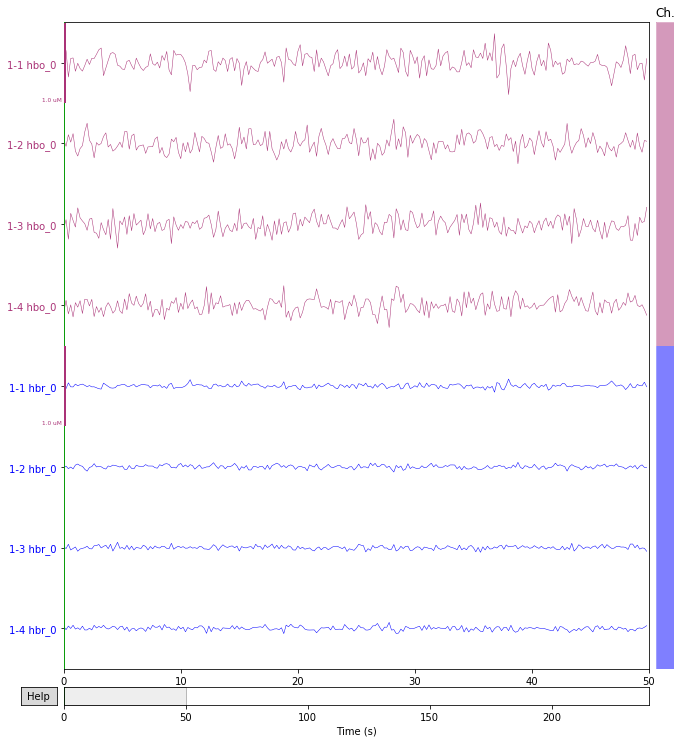

In [14]:
mne_ch_names_0 = [ch + ' ' + ch_types_0[i] + '_0'
                  for i, ch in enumerate(ch_names_0)]
print("MNE channel names: {}".format(mne_ch_names_0))
info_0 = mne.create_info(ch_names=mne_ch_names_0, sfreq=S_FREQ,
                         ch_types=ch_types_0)
raw_0 = mne.io.RawArray(dc_0, info_0)
graph_0 = raw_0.plot(scalings=0.5e-6, duration=50)